# EDA Notes

A first attempt at EDA for the CS109 final project. 

In [4]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn.model_selection import cross_val_score
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegressionCV
import seaborn as sns
%matplotlib inline
import json

**Read In Data**

In [5]:
checkins = pd.read_csv('Data/checkin_summary.csv', header=None)
photos = pd.read_csv('Data/photos_summary.csv', header=None)
reviews = pd.read_csv('Data/review_small.csv', header=None)
biz = pd.read_csv('Data/small_businesses.csv')
tips = pd.read_csv('Data/tip_summary.csv', header=None)
users = pd.read_json(path_or_buf='Data/user_small.json', lines=True)

/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (1,10,12,14,20,63,64,74) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Clean Columns and Data

In [6]:
users['elite_count'] = users.iloc[:,1].apply(lambda x: len(x))
users['join_date'] = pd.to_datetime(users['yelping_since'])
users.head()

,average_stars,elite,review_count,user_id,yelping_since,elite_count,join_date
0,3.80,"[2014, 2016, 2013, 2011, 2012, 2015, 2010, 2017]",272,lsSiIjAKVl-QRxKjRErBeg,2010-07-13,8,2010-07-13
1,3.94,"[2014, 2017, 2011, 2012, 2015, 2009, 2013, 200...",2559,om5ZiponkpRqUNa3pVPiRg,2006-01-18,12,2006-01-18
2,4.72,[],277,-lGwMGHMC_XihFJNKCJNRg,2014-10-31,0,2014-10-31
3,3.76,"[2016, 2017]",436,D-ydMTPGWXTVm4_jjp0k9g,2013-04-01,2,2013-04-01
4,4.23,"[2017, 2016]",921,PcvbBOCOcs6_suRDH7TSTg,2012-08-16,2,2012-08-16


In [7]:
users.dtypes

average_stars           float64
elite                    object
review_count              int64
user_id                  object
yelping_since            object
elite_count               int64
join_date        datetime64[ns]
dtype: object

In [8]:
checkins.shape, photos.shape, reviews.shape, biz.shape, tips.shape, users.shape

((49414, 2), (26384, 2), (2927859, 4), (38668, 93), (558979, 3), (1183362, 7))

In [9]:
checkins.columns = ['business_id', 'num_checkins'] 
checkins.head()

,business_id,num_checkins
0,--6MefnULPED_I942VcFNA,122
1,--9e1ONYQuAa-CB_Rrw7Tw,2469
2,--DaPTJW3-tB1vP-PfdTEg,88
3,--FBCX-N37CMYDfs790Bnw,477
4,--GM_ORV2cYS-h38DSaCLw,13


In [10]:
photos.columns = ['business_id', 'num_photos'] 
photos.head()

,business_id,num_photos
0,--6MefnULPED_I942VcFNA,1
1,--9e1ONYQuAa-CB_Rrw7Tw,127
2,--DaPTJW3-tB1vP-PfdTEg,1
3,--FBCX-N37CMYDfs790Bnw,4
4,--KCl2FvVQpvjzmZSPyviA,3


In [11]:
reviews.columns = ['user_id', 'business_id', 'rating', 'date'] 
reviews['review_date'] = pd.to_datetime(reviews['date'])
reviews.head()

,user_id,business_id,rating,date,review_date
0,V2exkc2JwEdc8UNUNhT7sg,--6MefnULPED_I942VcFNA,5,2016-08-25,2016-08-25
1,j97y1ZAsYABIOcR0KQCy5Q,--6MefnULPED_I942VcFNA,1,2010-12-06,2010-12-06
2,8-KBKMJVO-j5YqpHb08j9w,--6MefnULPED_I942VcFNA,4,2015-08-05,2015-08-05
3,CxDOIDnH8gp9KXzpBHJYXw,--6MefnULPED_I942VcFNA,2,2010-12-22,2010-12-22
4,7Dykd1HolQx8mKPYhYDYSg,--6MefnULPED_I942VcFNA,2,2017-02-07,2017-02-07


In [12]:
biz.columns=biz.columns.str.replace('attributes.','')
biz.columns=biz.columns.str.replace('.',"_")
biz.head()

,Ambience_divey,HairSpecializesIn_kids,RestaurantsDelivery,Open24Hours,Ambience_trendy,DogsAllowed,CoatCheck,postal_code,Smoking,DietaryRestrictions_halal,...,RestaurantsReservations,DietaryRestrictions_dairy-free,BestNights_wednesday,DietaryRestrictions_vegan,Ambience_romantic,Music_jukebox,Ambience_upscale,RestaurantsTakeOut,BikeParking,OutdoorSeating
0,False,NaN,False,NaN,False,NaN,False,28105,NaN,NaN,...,False,NaN,NaN,NaN,False,False,False,True,True,False
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28164,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2,True,NaN,False,NaN,False,NaN,NaN,15224,NaN,NaN,...,False,NaN,NaN,NaN,False,NaN,False,True,True,False
3,NaN,NaN,False,NaN,NaN,NaN,NaN,L5W 0E6,NaN,NaN,...,True,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,True
4,False,NaN,False,NaN,False,NaN,NaN,53704,NaN,NaN,...,True,NaN,NaN,NaN,False,NaN,False,True,True,False


In [13]:
tips.columns = ['business_id', 'user_id', 'unidentifiedinfo_tips'] 

tips['business_id'] = tips['business_id'].map(lambda x: x[1:])
tips['user_id'] = tips['user_id'].map(lambda x: x[:-1])
tips.head()

,business_id,user_id,unidentifiedinfo_tips
0,---1lKK3aKOuomHnwAkAow,0zoXYHq82haayMaV952jEQ,1
1,---1lKK3aKOuomHnwAkAow,A0X1baHPgw9IiBRivu0G9g,2
2,---1lKK3aKOuomHnwAkAow,Qy_tDaVTWlS14fEglzo1Tg,1
3,---1lKK3aKOuomHnwAkAow,RRw9I8pHt5PzgYGT2QeODw,1
4,---1lKK3aKOuomHnwAkAow,Xspg78dOvuedvuPEUwZBjw,1


In [14]:
# How many unique users are there in the tips data set?
print(len(tips.user_id.unique()))
print(len(tips.user_id.unique())/len(users))

43082
0.03640644198478572


Since these represent less than 4 percent of all users, we can disregard them for analysis.

## Explore User and Review Data

In [15]:
# Merge with review data
users_viz = users[['user_id', 'average_stars', 'review_count', 'elite_count', 'join_date']]
reviews_viz = reviews[['user_id', 'business_id', 'rating', 'review_date']]

In [16]:
user_review_viz = pd.merge(users_viz, reviews_viz, on='user_id', how='outer')

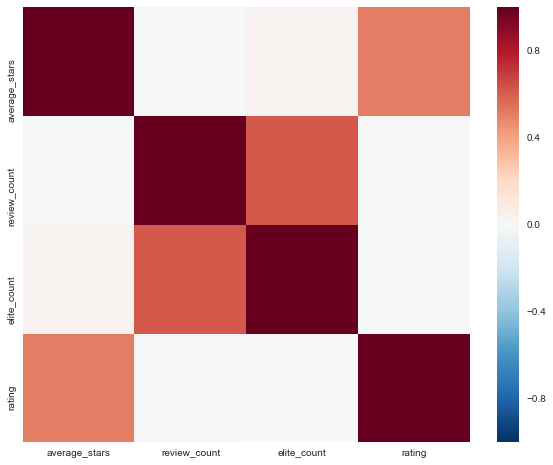

In [17]:
fig, ax = plt.subplots(1,1, figsize =(10,8))
sns.heatmap(user_review_viz.corr(), ax=ax)

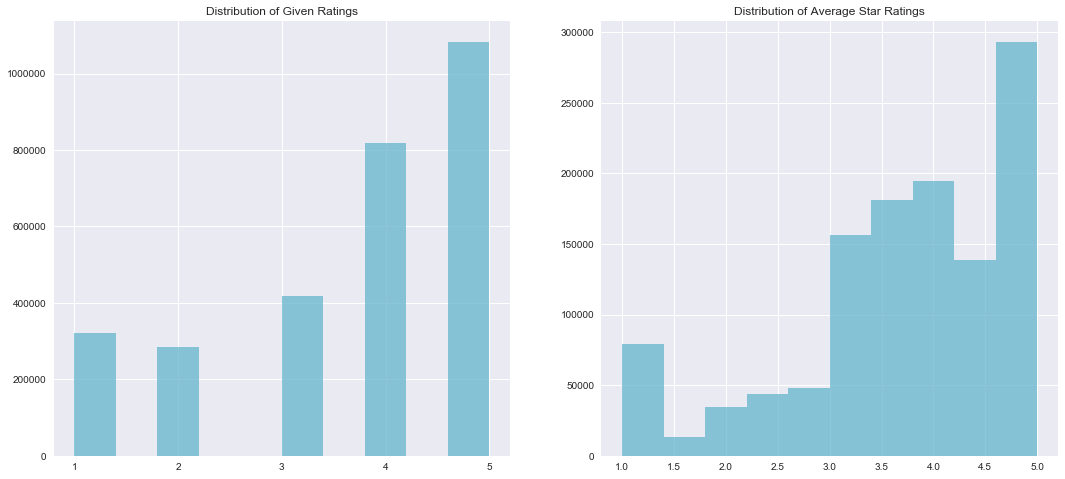

In [18]:
# How does the distribution of average rating compare to that of reviews
fig, ax = plt.subplots(1, 2, figsize=(18, 8))

plt.subplot(1, 2, 1)
plt.hist(reviews_viz.rating, color=sns.color_palette()[5], alpha=0.75, align='mid')
plt.xticks([1,2,3,4,5])
plt.title('Distribution of Given Ratings')

plt.subplot(1, 2, 2)
plt.hist(users_viz.average_stars, color=sns.color_palette()[5], alpha=0.75)
plt.title('Distribution of Average Star Ratings')

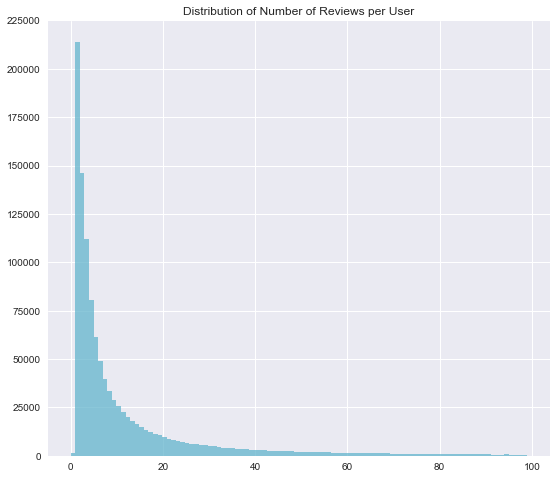

In [19]:
# What's the distribution of reviews?
fig, ax = plt.subplots(1, 1, figsize=(9, 8))

#plt.subplot(1, 2, 1)
plt.hist(users_viz.review_count[users_viz.review_count < 100], bins = 100, color=sns.color_palette()[5], alpha=0.75)
plt.title('Distribution of Number of Reviews per User')
#plt.subplot(1, 2, 2)
#plt.hist(users_viz.review_count[users_viz.review_count >= 100], bins = 50, color=sns.color_palette()[5], alpha=0.75)
#ax.set_xlim([20,1500])
#plt.xticks([1,2,3,4,5])


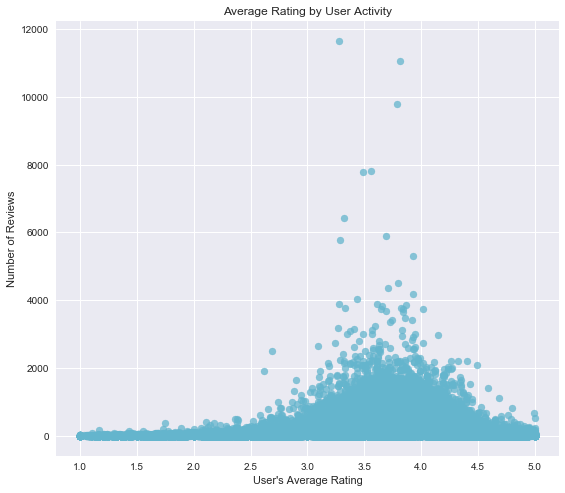

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(9, 8))
plt.scatter(users.average_stars, users.review_count, color=sns.color_palette()[5], alpha=0.75)
plt.xlabel("User's Average Rating")
plt.ylabel('Number of Reviews')
plt.title('Average Rating by User Activity')

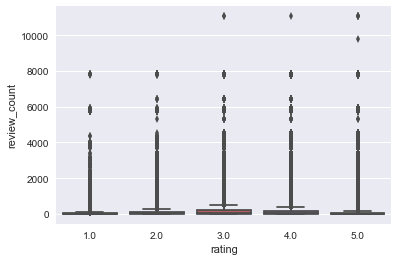

In [68]:
sns.boxplot('rating','review_count', data=user_review_viz)

In [56]:
elite_lvl = np.array(user_review_viz['elite_count'].unique())
elite_lvl.sort()

rating_props_1star = [user_review_viz.rating[(user_review_viz.rating == 1) & (user_review_viz.elite_count == i)].count()/user_review_viz.rating[user_review_viz.elite_count == i].count() for i in range(0,14)]
rating_props_2star = [user_review_viz.rating[(user_review_viz.rating == 2) & (user_review_viz.elite_count == i)].count()/user_review_viz.rating[user_review_viz.elite_count == i].count() for i in range(0,14)]
rating_props_3star = [user_review_viz.rating[(user_review_viz.rating == 3) & (user_review_viz.elite_count == i)].count()/user_review_viz.rating[user_review_viz.elite_count == i].count() for i in range(0,14)]
rating_props_4star = [user_review_viz.rating[(user_review_viz.rating == 4) & (user_review_viz.elite_count == i)].count()/user_review_viz.rating[user_review_viz.elite_count == i].count() for i in range(0,14)]
rating_props_5star = [user_review_viz.rating[(user_review_viz.rating == 5) & (user_review_viz.elite_count == i)].count()/user_review_viz.rating[user_review_viz.elite_count == i].count() for i in range(0,14)]

[1.0, 1.0, 1.0, 1.0, 0.99999999999999989, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99999999999999989]


([<matplotlib.axis.XTick at 0x17af7f780>,
 <a list of 14 Text xticklabel objects>)

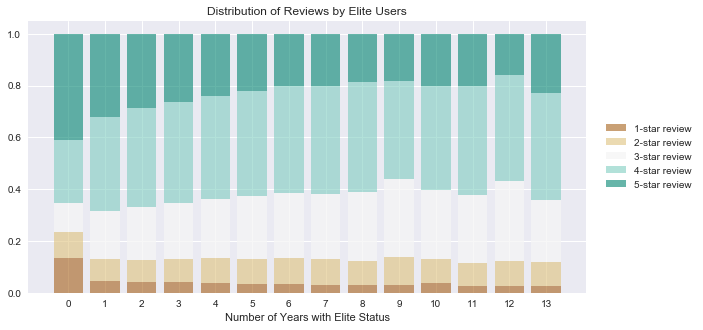

In [65]:
f, ax = plt.subplots(1, figsize=(10,5))

ax.bar(elite_lvl, rating_props_1star, label = '1-star review', alpha=0.6, color = '#a6611a')
ax.bar(elite_lvl, rating_props_2star, bottom = rating_props_1star, label = '2-star review', alpha=0.6, color = '#dfc27d')
ax.bar(elite_lvl, rating_props_3star, bottom = [i+j for i,j in zip(rating_props_1star, rating_props_2star)], label = '3-star review', alpha=0.8, color = '#f5f5f5')
ax.bar(elite_lvl, rating_props_4star, bottom = [i+j+k for i,j,k in zip(rating_props_1star, rating_props_2star, rating_props_3star)], label = '4-star review', alpha=0.6, color = '#80cdc1')
ax.bar(elite_lvl, rating_props_5star, bottom = [i+j+k+l for i,j,k,l in zip(rating_props_1star, rating_props_2star, rating_props_3star, rating_props_4star)], label = '5-star review', alpha=0.6, color = '#018571')

plt.xlabel("Number of Years with Elite Status")
plt.title('Distribution of Reviews by Elite Users')
plt.legend(bbox_to_anchor = (1.02,0.5) , loc = 'center left')
plt.xticks(range(0,14))

In [67]:
users.describe()

,average_stars,review_count,elite_count
count,1.183362e+06,1.183362e+06,1.183362e+06
mean,3.711835e+00,2.372686e+01,1.525848e-01
std,1.105231e+00,8.050645e+01,8.163861e-01
min,1.000000e+00,0.000000e+00,0.000000e+00
25%,3.130000e+00,2.000000e+00,0.000000e+00
50%,3.890000e+00,5.000000e+00,0.000000e+00
75%,4.570000e+00,1.600000e+01,0.000000e+00
max,5.000000e+00,1.165600e+04,1.300000e+01
